In [1]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

from matplotlib import pyplot as plt
import time
from gymnasium import Env
from gymnasium.spaces import Box, Discrete



# 2. Build the Environment


## 2.1 Create Environment

In [2]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(
            low=0, high=255, shape=(1, 83, 100), dtype=np.uint8
        )
        self.action_space = Discrete(3)
        # define extraction parameters
        self.cap = mss()
        self.game_location = {"top": 200, "left": 75, "width": 200, "height": 200}
        self.done_location = {"top": 270, "left": 450, "width": 200, "height": 40}
        self.up_location = {"top": 200, "left": 225, "width": 100, "height": 100}
        self.down_location = {"top": 310, "left": 275, "width": 100, "height": 100}
        # 400

    def step(self, action, variabila):
        # action key - 0 = space, 1 = Duck(down) 2 = No action (no op)
        action_map = {0: "space", 1: "down", 2: "no_op"}
        self.down_location["width"] = self.up_location["width"] + variabila
        self.up_location["width"] = self.up_location["width"] + variabila
        imgDown, imgUp, pressSpace, pressDown = self.get_enemies()

        if pressSpace == True:
            action = 0
        elif pressDown == True:
            action = 1

        # if action != 2:
        #     pydirectinput.press(action_map[action])

        if action == 0:
            pydirectinput.press(action_map[action])
        elif action == 1:
            pydirectinput.keyDown(action_map[action])
            time.sleep(0.5)
            pydirectinput.keyUp(action_map[action])

        # checking if the game is down
        done, done_cap = self.get_done()
        # get the next observation
        new_observation = self.get_observation()

        # reward = we get a point for every frame we are alive
        reward = 1
        # info dictionary
        info = {}

        truncated = done
        terminated = done

        return new_observation, reward, terminated, truncated, info

    def render(self):
        cv2.imshow("Game", self.current_frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            self.close()

    def reset(self, *, seed=None, options=None):
        #pydirectinput.keyUp("down")
        time.sleep(1)
        pydirectinput.click(x=350, y=350)
        pydirectinput.press("w")
        info = {}

        self.up_location = {"top": 200, "left": 225, "width": 100, "height": 100}
        self.down_location = {"top": 310, "left": 275, "width": 100, "height": 100}
        return self.get_observation(), {}

    # this closes down the observation
    def close(self):
        cv2.destroyAllWindows()

    # get the part of the observation of the game that we want
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:, :, :3]

        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)

        resized = cv2.resize(gray, (100, 83))

        channel = np.reshape(resized, (1, 83, 100))

        return channel

    # get the done text using OCR
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:, :, :3]

        gray = cv2.cvtColor(done_cap, cv2.COLOR_BGR2GRAY)

        _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

        kernel = np.ones((1, 1), np.uint8)
        thresh = cv2.dilate(thresh, kernel, iterations=1)

        results = pytesseract.image_to_string(thresh, lang="eng", config="--psm 7")
        res = results[:4]

        done_strings = ["Game", "GAHE"]
        
        #print(results)

        done = res in done_strings

        return done, done_cap

    def get_enemies(self):
        rawUp = np.array(self.cap.grab(self.up_location))[:, :, :3]
        grayUp = cv2.cvtColor(rawUp, cv2.COLOR_BGR2GRAY)

        rawDown = np.array(self.cap.grab(self.down_location))[:, :, :3]
        grayDown = cv2.cvtColor(rawDown, cv2.COLOR_BGR2GRAY)

        resizedDown = cv2.resize(grayDown, (300, 300))
        resizedUp = cv2.resize(grayUp, (300, 300))

        threshold = 100
        num_black_pixelsDown = np.sum(resizedDown < threshold)
        num_black_pixelsUp = np.sum(resizedUp < threshold)

        pressSpace = False
        pressDown = False
        if num_black_pixelsDown > 3000:
            pressSpace = True
        if num_black_pixelsUp > 2000:
            pressDown = True

        # print(f"Down {num_black_pixelsDown}")
        # print(f"Up {num_black_pixelsUp}")
        # print(f"PreesDown {pressSpace}, pressSpace {pressDown}")

        return resizedUp, resizedDown, pressSpace, pressDown

In [90]:
env = WebGame()

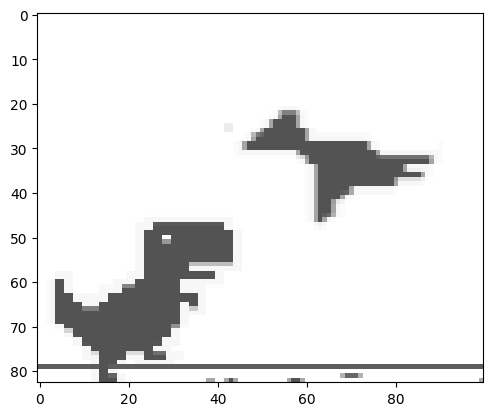

In [78]:
plt.imshow(cv2.cvtColor(env.get_observation()[0],cv2.COLOR_BGR2RGB))

In [91]:
up, down ,space,arrowDown = env.get_enemies()

Down 3764
Up 0
PreesDown True, pressSpace False


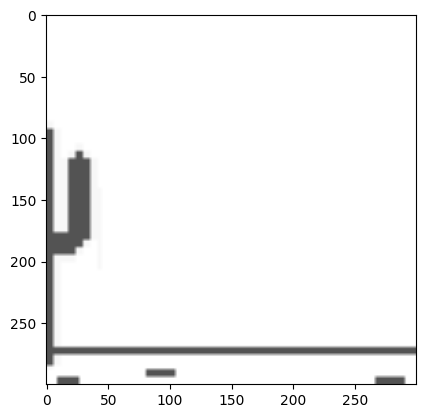

In [92]:
plt.imshow(cv2.cvtColor(down,cv2.COLOR_BGR2RGB))

## 2.2 Test Environment


In [136]:
env = WebGame()

In [108]:
obs = env.get_observation()

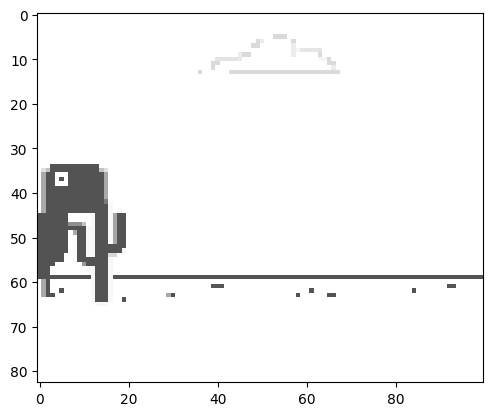

In [17]:
plt.imshow(cv2.cvtColor(obs[0],cv2.COLOR_BGR2RGB))

True


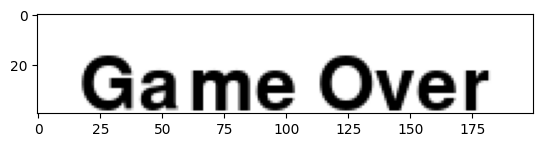

In [137]:
done, done_cap = env.get_done()
print(done)
plt.imshow(done_cap)

In [ ]:
for episode in range(10):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
        done = terminated
        total_reward += reward

    print(f"Total reward for epi {episode} is {total_reward}")

Total reward for epi 0 is 15
Total reward for epi 1 is 16
Total reward for epi 2 is 16
Total reward for epi 3 is 18
Total reward for epi 4 is 16
Total reward for epi 5 is 18
Total reward for epi 6 is 15
Total reward for epi 7 is 18
Total reward for epi 8 is 18
Total reward for epi 9 is 15


# 3 Train the Model

## 3.1 Create Callback

In [3]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [66]:
# check if the env is ok
env = WebGame()
env_checker.check_env(env)

PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False


In [4]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(
                self.save_path, "best_model_{}".format(self.n_calls)
            )
            self.model.save(model_path)

        return True

In [5]:
CHECKPOINT_DIR = "./train/"
LOG_DIR = "./logs/"

In [6]:
callback =  TrainAndLoggingCallback(check_freq=1000,save_path=CHECKPOINT_DIR)

## 3.2 Build DQN and Train

In [7]:
# import DQM algorithm
from stable_baselines3 import DQN

In [8]:
# create a DQN model
model = DQN(
    "CnnPolicy",
    env=env,
    tensorboard_log=LOG_DIR,
    verbose=1,
    buffer_size=1000000,
    learning_starts=1000,
)

NameError: name 'env' is not defined

In [72]:
# kick of training
model.learn(total_timesteps=5000, callback=callback)

Logging to ./logs/DQN_4
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSpace False
PreesDown False, pressSp

KeyboardInterrupt: 

# Test out Model

In [9]:
model = DQN.load(os.path.join("train", "best_model_88000"))

#model = DQN.load(os.path.join("train", "best_model_5000"))


FileNotFoundError: [Errno 2] No such file or directory: 'train\\best_model_88000.zip'

In [4]:
env = WebGame()

In [5]:

for episode in range(10):
    obs, info = env.reset()  # ← fixed line
    done = False
    total_reward = 0
    while not done:
        
        
        imgDown, imgUp, pressSpace, pressDown = env.get_enemies()
    
        #action, _ = model.predict(obs)
        auxVar = 0
        if pressSpace:
             action = 0
        elif pressDown:
            action = 1
        else:
            action =2
        
        obs, reward, terminated, truncated, info = env.step(int(action),int(total_reward/60))
        #obs, reward, terminated, truncated, info = env.step(int(action),0)
        done = terminated
        total_reward += reward
    print("Total Reward for episode {} is {}".format(episode, total_reward))


KeyboardInterrupt: 